In [9]:
import numpy as np
from stl import mesh
import matplotlib.pyplot as plt
%matplotlib qt

size_mlls=50 #in µm

coeff_x=0.00015 #in rad/mrad³
f_x=250 #in µm
coeff_y=0.00015 # in rad/mrad³
f_y=350 # in µm

N_lensletts=10

###########################
#Advanced
delta_PMMAmod_17_5=1.72e-6 #at 17.5keV. Obtained from "Nano-printed miniature compound refractive lens for desktop hard x-ray microscopy"
#by Mirzaeimoghri et al. I modified the tabulated density of PMMa in CXRO to 2.35 in order to get the same delta at 22 keV.
#At 17.5 keV i then get delta=1.72e-6

pillarwidth=10 #Width of the side pillars
scale_spacer=0#0.1 #Width of the central region between fish, relative to total lenslett curvature. Recommended for 2d CRCs or Vertical CRCs. 
postheight=20

px_size=1 # in µm

factor_size_x=1 #additional scaling of CRC compared to MLL
factor_size_y=1

factor_phase=1.0

bool_box=True
bool_post=True

flip_y=False

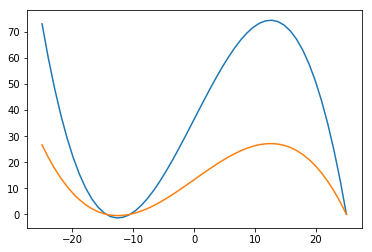

In [2]:
#get fish
xdim_o=size_mlls # in µm
ydim_o=size_mlls # in µm
def get_total_correction2(c,size_sfl_mll,factor_size_sfl,f_sfl,delta,pxsize=px_size):
    a_h=factor_size_sfl*size_sfl_mll/2
    c_mod=c*10**9/(f_sfl**3)
    phase_line_h_axis=np.linspace(-int(factor_size_sfl*size_sfl_mll)/2,int(factor_size_sfl*size_sfl_mll)/2,int(factor_size_sfl*size_sfl_mll/pxsize))
    phase_line_h=c_mod*(phase_line_h_axis**3 - a_h**2 * phase_line_h_axis)
    total_correction_pre=-phase_line_h-np.amin(phase_line_h)
    L=np.amax(total_correction_pre)/2
    n=np.amax(phase_line_h_axis)
    line=((-L)/(n*(1+1/np.sqrt(3))))*phase_line_h_axis-L/(np.sqrt(3)+1)
    if c_mod>0:
        total_correction=total_correction_pre+line
    else:
        total_correction=total_correction_pre-line-(L-L/(np.sqrt(3)+2))
    return(phase_line_h_axis,total_correction)

(pupil_size_arr_x,total_corr_arr_x)=get_total_correction2(c=coeff_x,size_sfl_mll=xdim_o,factor_size_sfl=factor_size_x,f_sfl=f_x,delta=delta_PMMAmod_17_5)
(pupil_size_arr_y,total_corr_arr_y)=get_total_correction2(c=coeff_y,size_sfl_mll=ydim_o,factor_size_sfl=factor_size_y,f_sfl=f_y,delta=delta_PMMAmod_17_5)
array=np.zeros((pupil_size_arr_y.shape[0],pupil_size_arr_x.shape[0]))
for i1 in range(0,array.shape[0]):
    for i2 in range(0,array.shape[1]):
        array[i1,i2]=total_corr_arr_x[i2]+total_corr_arr_y[i1]
plt.plot(pupil_size_arr_x,total_corr_arr_x)
plt.plot(pupil_size_arr_y,total_corr_arr_y)

(50, 50)
5.178301791872849
0.0


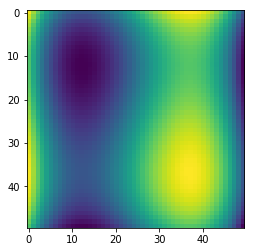

In [3]:
print(array.shape)
array=(array-np.amin(array))/(2*N_lensletts)
if factor_phase!=None:
    array=array*factor_phase
if flip_y==True:
    array=np.flip(array,axis=0)
maxheight=np.amax(array)
plt.imshow(array)
print(np.amax(array))
print(np.amin(array))


In [4]:
#make_box_template
xdim=np.float(xdim_o*factor_size_x)
xdimwall=pillarwidth
ydim=np.float(ydim_o*factor_size_y)
ydimwall=ydim
zdim=np.float(2*maxheight+scale_spacer*maxheight)


pxsize=xdim/array.shape[1]
sampling_z=100

In [5]:
def mk_mesh(vertices,faces):
    meshs=mesh.Mesh(np.zeros(len(faces),dtype=mesh.Mesh.dtype))
    for i, f in enumerate(faces):
                           for j in range(3):
                            #print(i,f[j])
                            #print(vertices[f[j]])
                            meshs.vectors[i][j]=vertices[f[j]]
    return(meshs)


Generating lenslett
4900 9796
made mesh


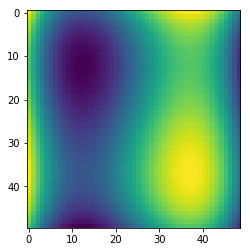

In [6]:
#the main box
%matplotlib inline
N_px_long=np.amax(array.shape)
N_px_short=np.amin(array.shape)

print("Generating lenslett")
def mk_vertices_faces(input_array,x_mid=0,y_mid=0,z_mid=0):

    array_new=np.zeros((N_px_long,N_px_long))
    array_new[array_new.shape[0]-array.shape[0]:array_new.shape[0],0:array.shape[1]]=array
    array_new=array_new[:,:-1]
    vertices=[]
    faces=[]
    i=0
    #make front vertices
    plt.imshow(array_new)
    for i1 in range(0,array_new.shape[0],1):
        for i2 in range(0,array_new.shape[1],1):
            vertices.append((array_new[i1,i2]+z_mid,(i2)*xdim/array_new.shape[1]+x_mid,(-i1)*ydim/array_new.shape[0]+y_mid))
    #make front faces
    for i1 in range(0,array_new.shape[0],1):
        for i2 in range(0,array_new.shape[1],1):
            if i1>=1:
                if i2>=0 and i2<(array_new.shape[1]-1):
                    faces.append((i,i-array_new.shape[1],i-array_new.shape[1]+1))
                if i2>=1:
                    faces.append((i-1,i-array_new.shape[1],i))
            i+=1
    #other side
    array_flip=array_new
    offset=len(vertices)
    i1=0
    i2=0
    i=0
    #make back vertices
    for i1 in range(0,array_new.shape[0],1):
        for i2 in range(0,array_new.shape[1],1):
            vertices.append((-array_flip[i1,i2]-z_mid,(i2)*xdim/array_flip.shape[1]+x_mid,(-i1)*ydim/array_flip.shape[0]+y_mid))

    #make back faces
    for i1 in range(0,array_new.shape[0],1):
        for i2 in range(0,array_new.shape[1],1):
            if i1>=1: 
                if i2>=0 and i2<(array_new.shape[1]-1):
                    faces.append(np.flip(np.add(offset,(i,i-array_new.shape[1],i-array_new.shape[1]+1)),axis=0))
                if i2>=1:
                    faces.append(np.flip(np.add(offset,(i-1,i-array_new.shape[1],i)),axis=0))
            i+=1

    #make_sides
    for i in range(0,array_flip.shape[1]-1):
        if i<(array_flip.shape[1]-1):
     #       #top
            faces.append(np.flip((i,i+1,offset+i),axis=0))
            faces.append(np.flip((i+1,offset+1+i,offset+i),axis=0))
            #bottom
            short=(array_new.shape[0]-1)*array_new.shape[1]+i
            faces.append((short,short+1,short+offset))
            faces.append(np.flip((short+offset,short+offset+1,short+1),axis=0))
        if i==(array_flip.shape[1]-1):
            #top
            faces.append(np.flip((i,i+1,offset+i),axis=0))
            #bottom
            short=(array_new.shape[0]-1)*array_new.shape[1]+i
            faces.append((short,short+1,short+offset))
    
    i=0
    for i in range(0,array_flip.shape[0]-1,1):
        #left
        faces.append(np.flip(((array_new.shape[1])*i,offset+i*(array_new.shape[1]),(i+1)*(array_new.shape[1])),axis=0))
        faces.append(np.flip(((array_new.shape[1])*(i+1),offset+i*(array_new.shape[1]),(i+1)*(array_new.shape[1])+offset),axis=0))

        
    for i in range(1,array_flip.shape[0],1):
    #    #right
        faces.append(((array_new.shape[1])*i-1,offset+(array_new.shape[1])*i-1,(array_new.shape[1])*(i+1)-1))
        faces.append(((array_new.shape[1])*(i+1)-1,offset+(array_new.shape[1])*i-1,offset+((array_new.shape[1])*(i+1))-1))
        #faces.append(np.flip(((array_new.shape[1])*i-1,offset+(array_new.shape[1])*i-1,(array_new.shape[1])*(i+1)-1),axis=0))
        #faces.append(np.flip(((array_new.shape[1])*(i+1)-1,offset+(array_new.shape[1])*i-1,offset+((array_new.shape[1])*(i+1))-1),axis=0))

    faces=np.array(faces)
    faces=np.flip(faces,axis=1)
    return(vertices,faces,array_new)
z_mid=(scale_spacer*maxheight/2)
front_vertices,front_faces,array_used=mk_vertices_faces(array,z_mid=z_mid)
print(len(front_vertices),len(front_faces))
#This is new with numpy-stl

lenslett_pre=mk_mesh(vertices=front_vertices,faces=front_faces)
#lenslett_pre=mesh.form_mesh(front_vertices,front_faces)
print("made mesh")



In [12]:
def mk_box(xmin,ymin,zmin,xmax,ymax,zmax):
        # Create 3 faces of a cube
    data = np.zeros(12, dtype=mesh.Mesh.dtype)

    # Top of the cube
    data['vectors'][0] = np.array(np.flip(([[xmin, ymax, zmax],
                                  [xmax, ymin, zmax],
                                  [xmin, ymin, zmax]]),axis=0))
    data['vectors'][1] = np.array(np.flip(([[xmax, ymin, zmax],
                                  [xmin, ymax, zmax],
                                  [xmax, ymax, zmax]]),axis=0))
    # Right face
    data['vectors'][2] = np.array(np.flip(([[xmax, ymin, zmin],
                                  [xmax, ymin, zmax],
                                  [xmax, ymax, zmin]]),axis=0))
    data['vectors'][3] = np.array([[xmax, ymax, zmax],
                                  [xmax, ymin, zmax],
                                  [xmax, ymax, zmin]])
    # Left face
    data['vectors'][4] = np.array([[xmin, ymin, zmin],
                                  [xmax, ymin, zmin],
                                  [xmax, ymin, zmax]])
    data['vectors'][5] = np.array(np.flip(([[xmin, ymin, zmin],
                                  [xmin, ymin, zmax],
                                  [xmax, ymin, zmax]]),axis=0))
    #Altleft face
    data['vectors'][6] = np.array([[xmin, ymax, zmax],
                                  [xmax, ymax, zmax],
                                  [xmin, ymax, zmin]])
    data['vectors'][7] = np.array([[xmax, ymax, zmax],
                                  [xmax, ymax, zmin],
                                  [xmin, ymax, zmin]])
    #Altrightface
    data['vectors'][8] = np.array(np.flip(([[xmin, ymax, zmin],
                                  [xmin, ymax, zmax],
                                  [xmin, ymin, zmax]]),axis=0))
    data['vectors'][9] = np.array(np.flip(([[xmin, ymax, zmin],
                                  [xmin, ymin, zmax],
                                  [xmin, ymin, zmin]]),axis=0))
    #Alttop
    data['vectors'][10] = np.array(np.flip(([[xmin, ymax, zmin],
                                  [xmin, ymin, zmin],
                                  [xmax, ymin, zmin]]),axis=0))
    data['vectors'][11] = np.array([[xmax, ymin, zmin],
                                  [xmin, ymax, zmin],
                                  [xmax, ymax, zmin]])
    #rotate
    for i in range(12):
        data["vectors"][i]=np.roll(data["vectors"][i],1,axis=1)
    #Bottom of the cube
    box=mesh.Mesh(data)
    return(box)

if bool_box==True:
    boxoverlap=0 #overlap side boxes, factor compared to xdim
    yoffset=-ydim*(array_used.shape[0]-1)/(array_used.shape[0])
    xmin1=-pillarwidth-boxoverlap*xdim
    ymin1=yoffset+0.001
    zmin1=-z_mid-maxheight
    xmax1=boxoverlap*xdim
    ymax1=0
    zmax1=z_mid+maxheight
    
    xmin2=(array_used.shape[1]-1)*xdim/array_used.shape[1]-boxoverlap*xdim
    ymin2=yoffset+0.001
    zmin2=-z_mid-maxheight
    xmax2=xdim+pillarwidth
    ymax2=0
    zmax2=z_mid+maxheight
    
    box1=mk_box(xmin1,ymin1,zmin1,xmax1,ymax1,zmax1)
    box2=mk_box(xmin2,ymin2,zmin2,xmax2,ymax2,zmax2)
    
if bool_post==True:
    yoffset=-ydim*(array_used.shape[0]-1)/(array_used.shape[0])
    xminp=-pillarwidth-boxoverlap*xdim
    yminp=yoffset-postheight
    zminp=-z_mid-maxheight
    xmaxp=xdim+pillarwidth
    ymaxp=yoffset
    zmaxp=z_mid+maxheight
    post=mk_box(xminp,yminp,zminp,xmaxp,ymaxp,zmaxp)


#use lenslett_pre, box1,box2,post

In [20]:
# find the max dimensions, so we can know the bounding box, getting the height,
# width, length (because these are the step size)...
import stl
import math
import numpy
def find_mins_maxs(obj):
    minx = maxx = miny = maxy = minz = maxz = None
    for p in obj.points:
        # p contains (x, y, z)
        if minx is None:
            minx = p[stl.Dimension.X]
            maxx = p[stl.Dimension.X]
            miny = p[stl.Dimension.Y]
            maxy = p[stl.Dimension.Y]
            minz = p[stl.Dimension.Z]
            maxz = p[stl.Dimension.Z]
        else:
            maxx = max(p[stl.Dimension.X], maxx)
            minx = min(p[stl.Dimension.X], minx)
            maxy = max(p[stl.Dimension.Y], maxy)
            miny = min(p[stl.Dimension.Y], miny)
            maxz = max(p[stl.Dimension.Z], maxz)
            minz = min(p[stl.Dimension.Z], minz)
    return minx, maxx, miny, maxy, minz, maxz


def translate(_solid, step, padding, multiplier, axis):
    if axis == 'x':
        items = [0, 3, 6]
    elif axis == 'y':
        items = [1, 4, 7]
    elif axis == 'z':
        items = [2, 5, 8]
    for p in _solid.points:
        # point items are ((x, y, z), (x, y, z), (x, y, z))
        for i in range(3):
            p[items[i]] += (step * multiplier) + (padding * multiplier)


def copy_obj(obj, dims, num_rows, num_cols, num_layers):
    w, l, h = dims
    copies = []
    for layer in range(num_layers):
        for row in range(num_rows):
            for col in range(num_cols):
                # skip the position where original being copied is
                if row == 0 and col == 0 and layer == 0:
                    continue
                _copy = mesh.Mesh(obj.data.copy())
                # pad the space between objects by 10% of the dimension being
                # translated
                if col != 0:
                    translate(_copy, w, 0., col, 'x')
                if row != 0:
                    translate(_copy, l, l / 10., row, 'y')
                if layer != 0:
                    translate(_copy, h, h / 10., layer, 'z')
                copies.append(_copy)
    return copies

# Using an existing stl file:
main_body = lenslett_pre

# rotate along Y
#main_body.rotate([0.0, 0.5, 0.0], math.radians(90))




combined1 = mesh.Mesh(numpy.concatenate(
                                    #[copy.data for copy in copies])) #+
                                    [main_body.data, box1.data, box2.data , post.data] ))
                                    #[copy.data for copy in copies2]))

#Now making N lensletts
tile_offset=2*maxheight+2*z_mid
minx, maxx, miny, maxy, minz, maxz = find_mins_maxs(combined1)
w1 = maxx - minx
l1 = maxy - miny
h1 = maxz - minz
print(tile_offset,w1,l1,h1)
copies = copy_obj(combined1, (tile_offset, l1, h1), 1, N_lensletts, 1)
CRC=mesh.Mesh(np.concatenate([copy.data for copy in copies]))
CRC.save('CRC.stl', mode=stl.Mode.ASCII)  # save as ASCII
width_total=2*pillarwidth+xdim
height_total=ydim
depth_total=N_lensletts*(2*maxheight+2*z_mid)
print("expected size (x,y,z): ",(width_total,height_total,depth_total))
print("Done")

10.356603583745699 10.356604 70.0 69.0
expected size (x,y,z):  (70.0, 50.0, 103.56603583745698)
Done


In [75]:

#old
    

vertices_crc=np.copy(lenslett.vertices)
faces_crc=np.copy(lenslett.faces)
voxels_crc=np.copy(lenslett.voxels)

vertices_append=np.copy(vertices_crc)
faces_append=np.copy(faces_crc)
voxels_append=np.copy(voxels_crc)
tile_offset=2*maxheight+2*z_mid


for i in range(1,N_lensletts,1):
    N_vertices=vertices_crc.shape[0]
    vertices_append_now=vertices_append
    vertices_append_now[:,0]=vertices_append_now[:,0]+tile_offset
    vertices_crc=np.append(vertices_crc,vertices_append_now,axis=0)
    faces_append_now=faces_append[:,:]+N_vertices
    faces_crc=np.append(faces_crc,faces_append_now,axis=0)
    voxels_append_now=voxels_append


CRC=pymesh.form_mesh(vertices_crc,faces_crc)

#creating boxes
width_total=2*pillarwidth+xdim
height_total=ydim
depth_total=N_lensletts*(2*maxheight+2*z_mid)
print("expected size (x,y,z): ",(width_total,height_total,depth_total))
print("Done")



if factor_phase==None:
    fnam="CRC.stl"
    pymesh.save_mesh(fnam,CRC)
else:
    phasefac_string="{0:.2f}".format(factor_phase)
    phasefac_string=phasefac_string.replace('.', '_')
    fnam="CRC_{0}.stl".format(phasefac_string)
    pymesh.save_mesh(fnam,CRC)
plt.xlabel("size (µm)")
plt.ylabel("size (µm)")
extent=(0,factor_size_x*xdim_o,0,factor_size_y*ydim_o)
plt.imshow(array_used,extent=extent)
plt.colorbar(label="height (µm)")
plt.title("Thickness profile per half lenslett(half fish)")
plt.savefig(fnam[:-4]+".png",dpi=300)
plt.close()
print("Saved as {0}".format(fnam))

NameError: name 'pymesh' is not defined

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  # This is added back by InteractiveShellApp.init_path()


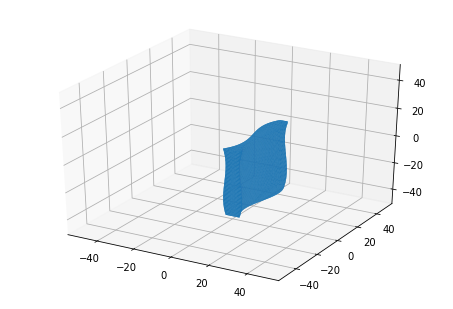

In [68]:
from mpl_toolkits import mplot3d
%matplotlib qt
# Create a new plot
figure = plt.figure()
axes = mplot3d.Axes3D(figure)

# Load the STL files and add the vectors to the plot
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(lenslett_pre.vectors))

# Auto scale to the mesh size
scale = lenslett_pre.points.flatten(-1)
axes.auto_scale_xyz(scale, scale, scale)

# Show the plot to the screen
plt.show()
#lenslett_pre.save("lenslett.stl")